
Logistic Regressions
------------

We would like to use an example to show how the sparse-constrained optimization for logistic regression works in our program.

### Introduction

Logistic regression is an important model to solve classification problem, which is expressed specifically as:
$$
\begin{aligned}
& P(y=1 \mid x)=\frac{1}{1+\exp \left(-x^T \beta\right)}, \\
& P(y=0 \mid x)=\frac{1}{1+\exp \left(x^T \beta\right)},
\end{aligned}
$$
where $\beta$ is an unknown parameter vector that to be estimated. Since we expect only a few explanatory variables contributing to predicting $y$, we assume $\beta$ is sparse vector with sparsity level $s$.

With $n$ independent data of the explanatory variables $x$ and the response variable $y$, we can estimate $\beta$ by minimizing the negative log-likelihood function under sparsity constraint:

<a id='loss'></a>
$$
\arg \min _{\beta \in R^p} L(\beta):=-\frac{1}{n} \sum_{i=1}^n\left\{y_i x_i^T \beta-\log \left(1+\exp \left(x_i^T \beta\right)\right)\right\}, \text { s.t. }\|\beta\|_0 \leq s \tag{1}
$$ 

### Import necessary packages

In [2]:
import jax.numpy as jnp
import numpy as np
from skscope import ScopeSolver
import numpy as np

### Set a seed

In [13]:
np.random.seed(123)

### Generate the data

Firstly, we define a data generator function to provide a way to generate suitable dataset for this task.

The model:

* $\beta^*_i$ ~ U(1, 2), $\forall i \in supp(\beta^*)$
* $x = (x_1, \cdots, x_p)^T$, $x_{i+1}=\rho x_i+\sqrt{1-\rho^2}z_i$, where $x_1, z_i$ ~ N(0, 1)
* $y\in\{0,1\}$, $P(y=0)=\frac{1}{1+\exp^{x^T\beta^*+c}}$

In [4]:
def make_logistic_data(n, p, s, rho, random_state=None):
    np.random.seed(random_state)
    # beta
    beta = np.zeros(p)
    true_support_set = np.random.choice(p, s, replace=False)
    beta[true_support_set] = np.random.uniform(1, 2, s)
    # X
    X = np.empty((n, p))
    X[:, 0] = np.random.normal(0, 1, n)
    for j in range(1, p):
        X[:, j] = rho * X[:, j - 1] + np.sqrt(1-rho**2) * np.random.normal(0, 1, n)
    # y
    xbeta = np.clip(X @ beta, -30, 30)
    p = 1 / (1 + np.exp(-xbeta))
    y = np.random.binomial(1, p)

    return X, y, beta, true_support_set

We then use this function to generate a data set containg 500 observations and set only 5 of the 500 variables to have effect on the expectation of the response.

In [5]:
n, p, s, rho = 500, 500, 5, 0.0
X, y, true_params, true_support_set = make_logistic_data(n, p, s, rho , 0)

print("The predictor variables of the first five samples:",'\n',X[:,:5])
print("The first five noisy observations:", '\n', y[:5])

The predictor variables of the first five samples: 
 [[ 0.69737282  0.03450501  0.42336761 -1.0105109   0.80309684]
 [-1.73742924 -0.93030375  1.17768213 -0.20897476 -0.45380626]
 [ 0.1158557   0.88898011  1.84867083  0.89752944  1.0140089 ]
 ...
 [-0.72372136  0.93656552  0.50196949 -0.46074581 -1.01287755]
 [ 1.7275667   0.66641827  0.58307715 -0.26071243 -0.93833324]
 [ 0.05005725 -0.19198389  1.03978649 -2.95108931 -1.18655014]]
The first five noisy observations: 
 [0 1 1 1 1]


### Define function to calculate negative log-likelihood of logistic regression

Secondly, we define the loss function `logistic_loss` accorting to [1](#loss) that matches the data generating function `make_logistic_data`.

In [6]:
def logistic_loss(params):
    xbeta = jnp.clip(X @ params, -30, 30)
    return jnp.mean(jnp.log(1 + jnp.exp(xbeta)) - y * xbeta)

### Use skscope to solve the sparse logistic regression problem

After defining the data generation and loss function, we can call `ScopeSolver` to solve the sparse-constrained optimization problem.

In [7]:
solver = ScopeSolver(p, s)
params = solver.solve(logistic_loss, jit=True)

Now the `solver.params` contains the coefficients of logistic model with no more than 5 variables. That is, those variables with a coefficient 0 is unused in the model:

In [8]:
print(solver.params)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.28832619 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

We can further compare the coefficients estimated by `skscope` and the real coefficients in three-fold:

* The true support set and the estimated support set

* The true nonzero parameters and the estimated nonzero parameters

* The true loss value and the estimated values

In [9]:
print("True support set: ", (true_support_set))
print("Estimated support set: ", (solver.support_set))

True support set:  [ 90 254 283 445 461]
Estimated support set:  [ 90 254 283 445 461]


In [10]:
print("True parameters: ", true_params[true_support_set])
print("Estimated parameters: ", solver.params[solver.support_set])

True parameters:  [1.45985588 1.0446123  1.79979588 1.07695645 1.51883515]
Estimated parameters:  [1.28832619 1.25065104 1.80884759 1.11876537 1.44894047]


In [11]:
print("True loss value: ", logistic_loss(true_params))
print("Estimated loss value: ", logistic_loss(solver.params))

True loss value:  0.34673184
Estimated loss value:  0.3428498


### More on the results

We can plot the sparse signal recovering from the noisy observations to visualize the results.

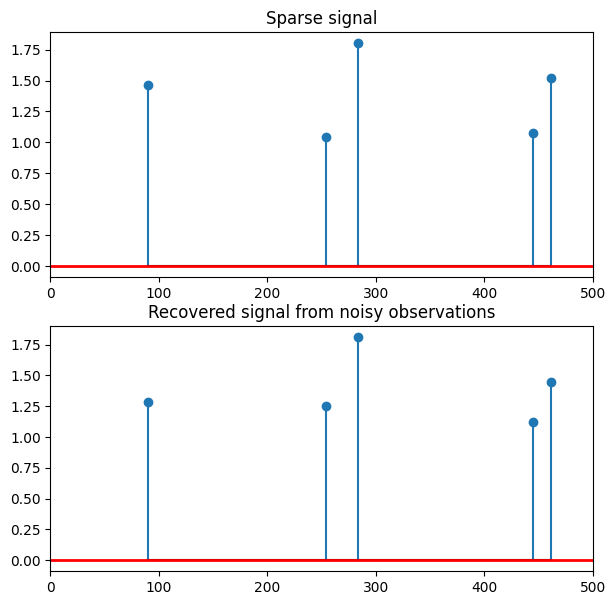

In [12]:
import matplotlib.pyplot as plt
(inx_true,) =  true_params.nonzero()
(inx_est,) =  solver.params.nonzero()

# plot the sparse signal
plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.stem(inx_true, true_params[inx_true], markerfmt='o', basefmt='k-')
plt.plot([0, 500], [0, 0], 'r-', lw=2)
plt.xlim(0, 500)
plt.title("Sparse signal")
#plt.plot(inx_true, true_params[inx_true], drawstyle='steps-post')

# plot the noisy reconstruction
plt.subplot(2, 1, 2)
plt.stem(inx_est, solver.params[inx_est], markerfmt='o', basefmt='k-')
plt.plot([0, 500], [0, 0], 'r-', lw=2)
plt.xlim(0, 500)
plt.title("Recovered signal from noisy observations")
#plt.plot(inx_est, solver.params[inx_est], drawstyle='steps-post')

plt.show()